# Problem Statement ❔

The *Bank Marketing data Set* from the UCI Machine Learning Repository is related with direct marketing campaigns (phone calls) of a Portuguese banking institution.

The classification goal is to predict if the client will subscribe a term deposit (variable y). You can find a description of the attributes at the [original UCI URL](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing)

The UCI page contains multiple versions of the data, so the version that you need to work with is here:

- [Bank Marketing data](/data/bank-marketing-dataset.csv)


Your task is to build two classifiers for this data set: a decision tree and a naïve Bayes classifier. Use a suitable evaluation metric to compare the performance of the three classifiers.

# Solution ✅

## Decision Tree Classifier 🌲

#### 1.1 Packages Import

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz as gviz
import missingno as msno

from sklearn.preprocessing import OrdinalEncoder

from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, make_scorer

from datetime import datetime
import calendar

from time import perf_counter_ns as perf
import pickle

from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

In [2]:
model_count = 0

#### 1.2 Extract CSV data into pandas DataFrame

In [3]:
df_original = pd.read_csv("./datasets/bank-marketing-dataset.csv")

### 2. Data Description

#### 2.1 Top 5 records

In [4]:
df_original.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,43,self-employed,divorced,university.degree,no,no,no,cellular,aug,mon,...,1,999,1,failure,-2.9,92.201,-31.4,0.884,5076.2,no
1,74,retired,married,high.school,no,yes,no,cellular,aug,thu,...,1,999,1,failure,-2.9,92.201,-31.4,0.883,5076.2,yes
2,34,technician,single,professional.course,no,yes,no,cellular,aug,tue,...,2,12,1,success,-2.9,92.201,-31.4,0.883,5076.2,yes
3,50,blue-collar,married,unknown,no,yes,no,cellular,aug,tue,...,1,999,0,nonexistent,-2.9,92.201,-31.4,0.883,5076.2,no
4,27,admin.,single,university.degree,no,no,no,cellular,aug,wed,...,2,999,0,nonexistent,-2.9,92.201,-31.4,0.879,5076.2,yes


#### 2.2 Shape of the dataset

In [5]:
print(f'Count of (Records, Features) = {df_original.shape}')

Count of (Records, Features) = (41188, 21)


#### 2.3 Datatype of features

In [6]:
feature_description = df_original.dtypes
display(feature_description)

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

##### Seperate features based on the datatype

In [7]:
categorical_features = feature_description[feature_description=='O'].index
discrete_numerical_features = feature_description[feature_description=='int64'].index
continuous_numerical_features = feature_description[feature_description=='float'].index

print(f'There are {len(categorical_features)} Categorical, {len(discrete_numerical_features)} Discrete Numerical and {len(continuous_numerical_features)} Continuous Numerical features in the dataset.')

There are 11 Categorical, 5 Discrete Numerical and 5 Continuous Numerical features in the dataset.


### 3. Data Checks to perform

- Check Duplicates
- Check data types and unique values of each column
- Check unique items in each Categorical feature
- Check missing values
- Check statistics of numerical variables of the dataset
- Check collinearity among the Numerical variables

#### 3.1 Check Duplicates

In [8]:
df_original.duplicated().sum()

12

#### 3.2 Check data types and unique values of each column

In [9]:
feature_description = pd.DataFrame(pd.concat([df_original.dtypes, df_original.nunique()], axis=1).rename(columns={0:'datatype', 1:'unique_value_count'}))

print(feature_description)

               datatype  unique_value_count
age               int64                  78
job              object                  12
marital          object                   4
education        object                   8
default          object                   3
housing          object                   3
loan             object                   3
contact          object                   2
month            object                  10
day_of_week      object                   5
duration          int64                1544
campaign          int64                  42
pdays             int64                  27
previous          int64                   8
poutcome         object                   3
emp.var.rate    float64                  10
cons.price.idx  float64                  26
cons.conf.idx   float64                  26
euribor3m       float64                 316
nr.employed     float64                  11
y                object                   2


#### 3.3 Check unique categories in each Categorical feature

In [10]:
for feature in categorical_features:
    print(f'Categories in {feature.upper()} variable:\n{df_original[feature].unique()}\n')

Categories in JOB variable:
['self-employed' 'retired' 'technician' 'blue-collar' 'admin.'
 'management' 'housemaid' 'student' 'services' 'unemployed' 'entrepreneur'
 'unknown']

Categories in MARITAL variable:
['divorced' 'married' 'single' 'unknown']

Categories in EDUCATION variable:
['university.degree' 'high.school' 'professional.course' 'unknown'
 'basic.6y' 'basic.9y' 'basic.4y' 'illiterate']

Categories in DEFAULT variable:
['no' 'unknown' 'yes']

Categories in HOUSING variable:
['no' 'yes' 'unknown']

Categories in LOAN variable:
['no' 'yes' 'unknown']

Categories in CONTACT variable:
['cellular' 'telephone']

Categories in MONTH variable:
['aug' 'sep' 'oct' 'jul' 'nov' 'dec' 'mar' 'may' 'jun' 'apr']

Categories in DAY_OF_WEEK variable:
['mon' 'thu' 'tue' 'wed' 'fri']

Categories in POUTCOME variable:
['failure' 'success' 'nonexistent']

Categories in Y variable:
['no' 'yes']



#### 3.2 Check Missing values

In [11]:
df_original.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

> As checked in **3.1**, some of the categorical features consists of the value `unknown`. Unless we claim it to be a seperate category, it can be seen as missing values. If so, our previous claim of this dataset not having any missing value proves to be wrong.
> >
> If we check the dataset in terms of standard `NaN` values, we could not find any missing values.
> >
> But if we search for string `unknown` and treat it as a missing value, we could find, it is distributed through multiple attributes in the following magnitude.

In [12]:
# df_original = df_original.copy()
df_original.replace('unknown', np.nan, inplace=True)

# count of missing values/unknowns
missing = df_original.isna().sum()
missing

age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

In [13]:
feature_description['percent_missing'] = round(missing/len(df_original) *100,1)

print(feature_description)

               datatype  unique_value_count  percent_missing
age               int64                  78              0.0
job              object                  12              0.8
marital          object                   4              0.2
education        object                   8              4.2
default          object                   3             20.9
housing          object                   3              2.4
loan             object                   3              2.4
contact          object                   2              0.0
month            object                  10              0.0
day_of_week      object                   5              0.0
duration          int64                1544              0.0
campaign          int64                  42              0.0
pdays             int64                  27              0.0
previous          int64                   8              0.0
poutcome         object                   3              0.0
emp.var.rate    float64 

##### All the features which have **Missing Values** belong to **object** datatype.

#### 3.5. Check statistics of numerical variables of the dataset

In [14]:
df_original.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


#### 3.6. Check collinearity among the Numerical variables

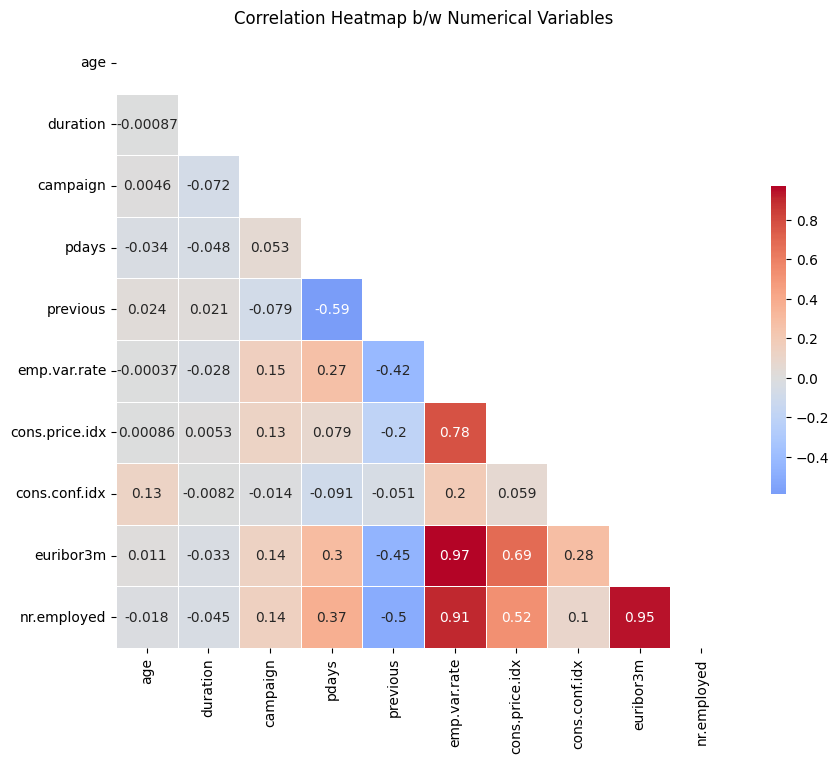

In [15]:
# Compute the correlation matrix
corr = df_original.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 8))

# Generate the heatmap with Seaborn
sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Set the title of the plot
plt.title('Correlation Heatmap b/w Numerical Variables')

# Show the plot
plt.show()

- ##### Insight
> Variables like `euribor3m`, `nr.employed` and `emp.var.rate` have a correlation factor *> 0.9* with each other. Which suggest that, these variables are very strongly correlated with each other. Therefore keeping all of them in the dataset increases collinearity among explanatory variables which increases variance and thus leads to *Overfitted* model.
>
> As we know, Decision Tree models are highly prone to overfitting. Thus decreasing collinearity happens to be one of the most significant preprocessing for optimal Decision Tree model building.

### 4 Data Cleaning

#### 4.1 Drop Columns

##### `duration` column

This attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the `duration` is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

In [16]:
df_original = df_original.drop(columns=['duration'])

##### `day_of_week` column

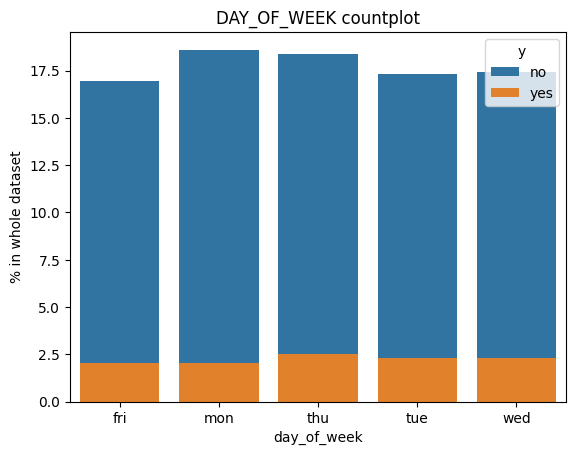

In [17]:
prop_df = df_original.groupby(['day_of_week','y']).count()['age']
prop_df = round(prop_df/sum(prop_df)*100,2)
prop_df = prop_df.reset_index()

# Create the stacked bar plot
sns.barplot(x='day_of_week', y='age', hue='y', data=prop_df, dodge=False)

# Add legend and set title
plt.legend(title='y')
plt.ylabel('% in whole dataset')
plt.title('DAY_OF_WEEK countplot')

# Show the plot
plt.show()


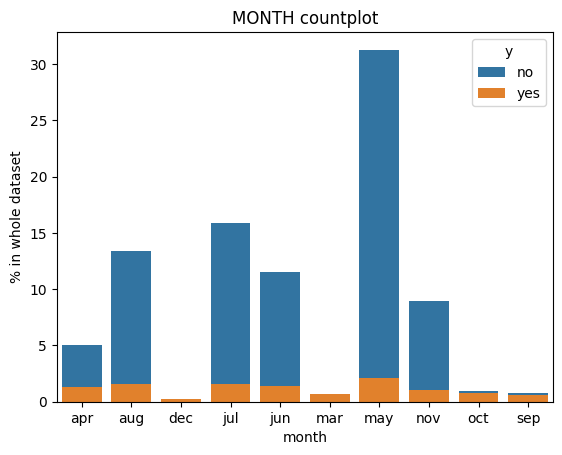

In [18]:
prop_df = df_original.groupby(['month','y']).count()['age']
prop_df = round(prop_df/sum(prop_df)*100,2)
prop_df = prop_df.reset_index()

# Create the stacked bar plot
sns.barplot(x='month', y='age', hue='y', data=prop_df, dodge=False)

# Add legend and set title
plt.legend(title='y')
plt.ylabel('% in whole dataset')
plt.title('MONTH countplot')

# Show the plot
plt.show()


As we can see proportion of responses (`yes`, `no`) is nearly similar in each `day_of_week` class. Therefore, keeping `day_of_week` attribute would add negligible, if any, information gain into our model. So we can safely drop this.

In [19]:
df_original = df_original.drop(columns=['day_of_week'])

#### 4.2 Analysis for dropping the records with misssing values

##### Distribution and correlation of missing vlaues (`NaN`) among features

<Axes: >

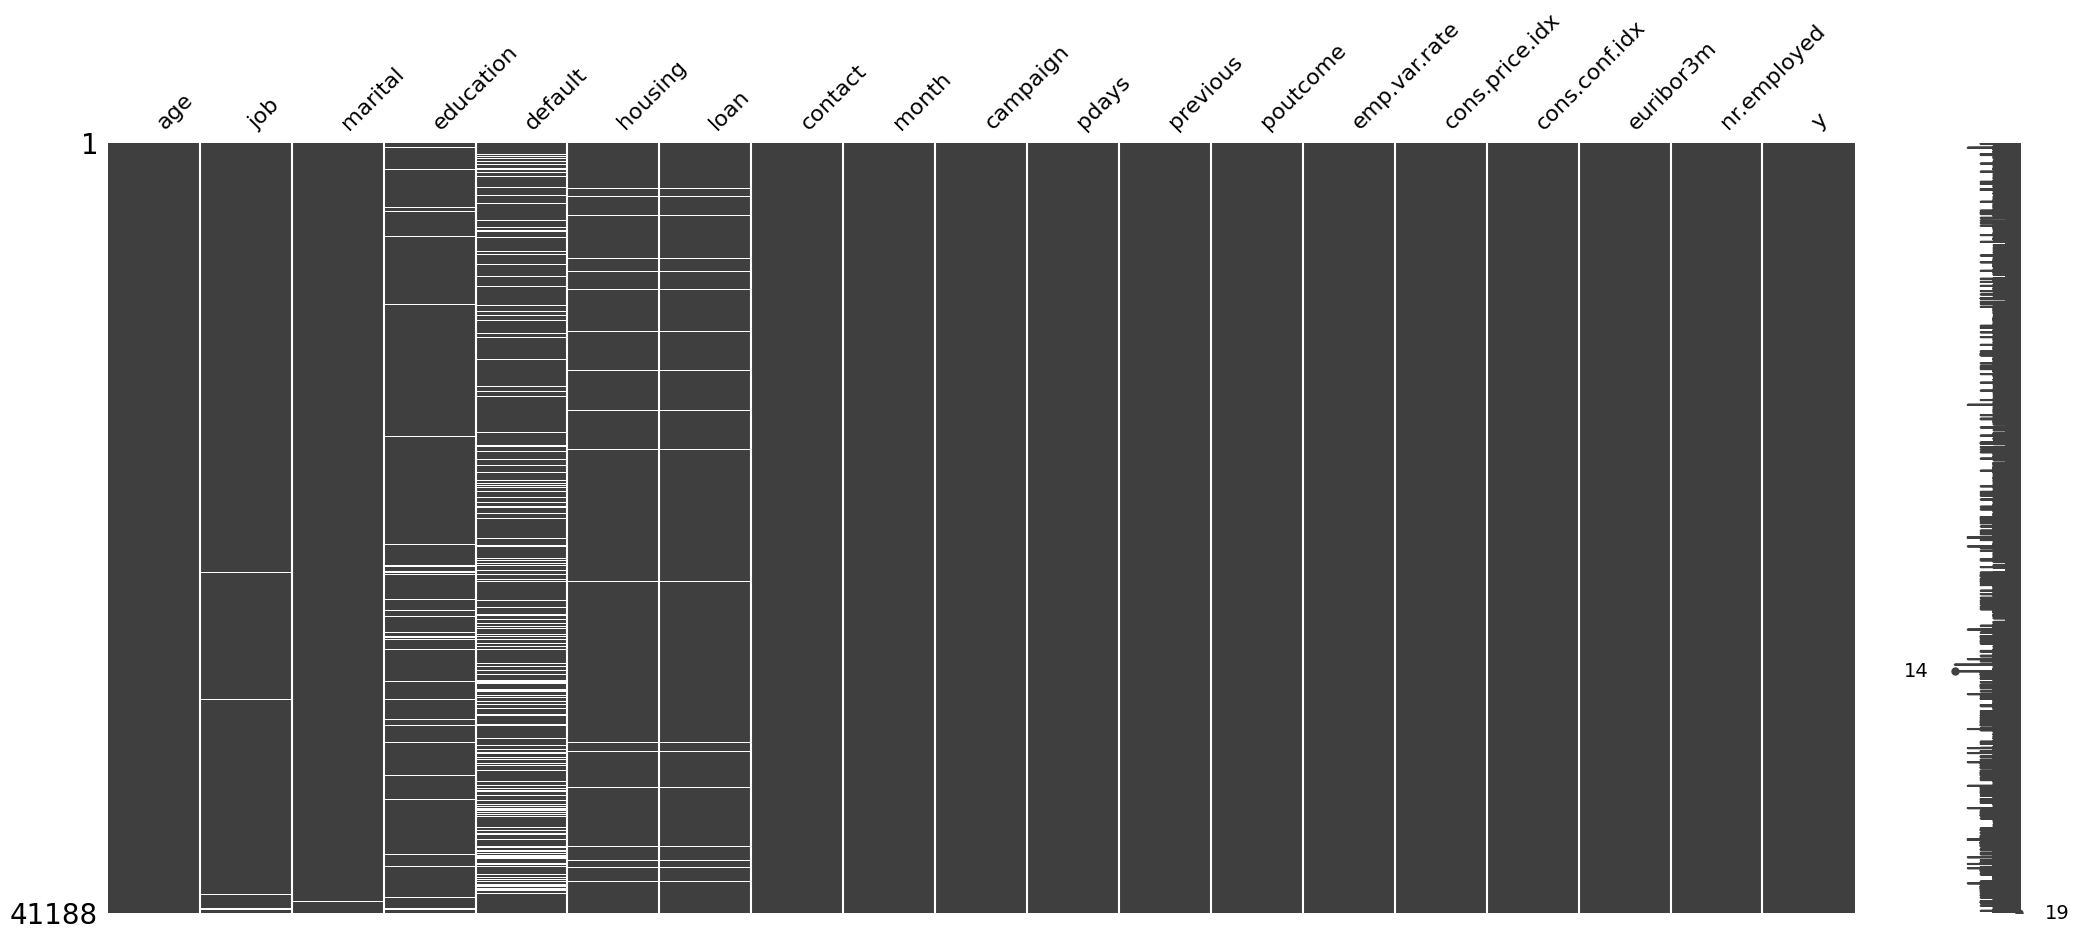

In [20]:
msno.matrix(df_original.sort_values('age'))

<Axes: >

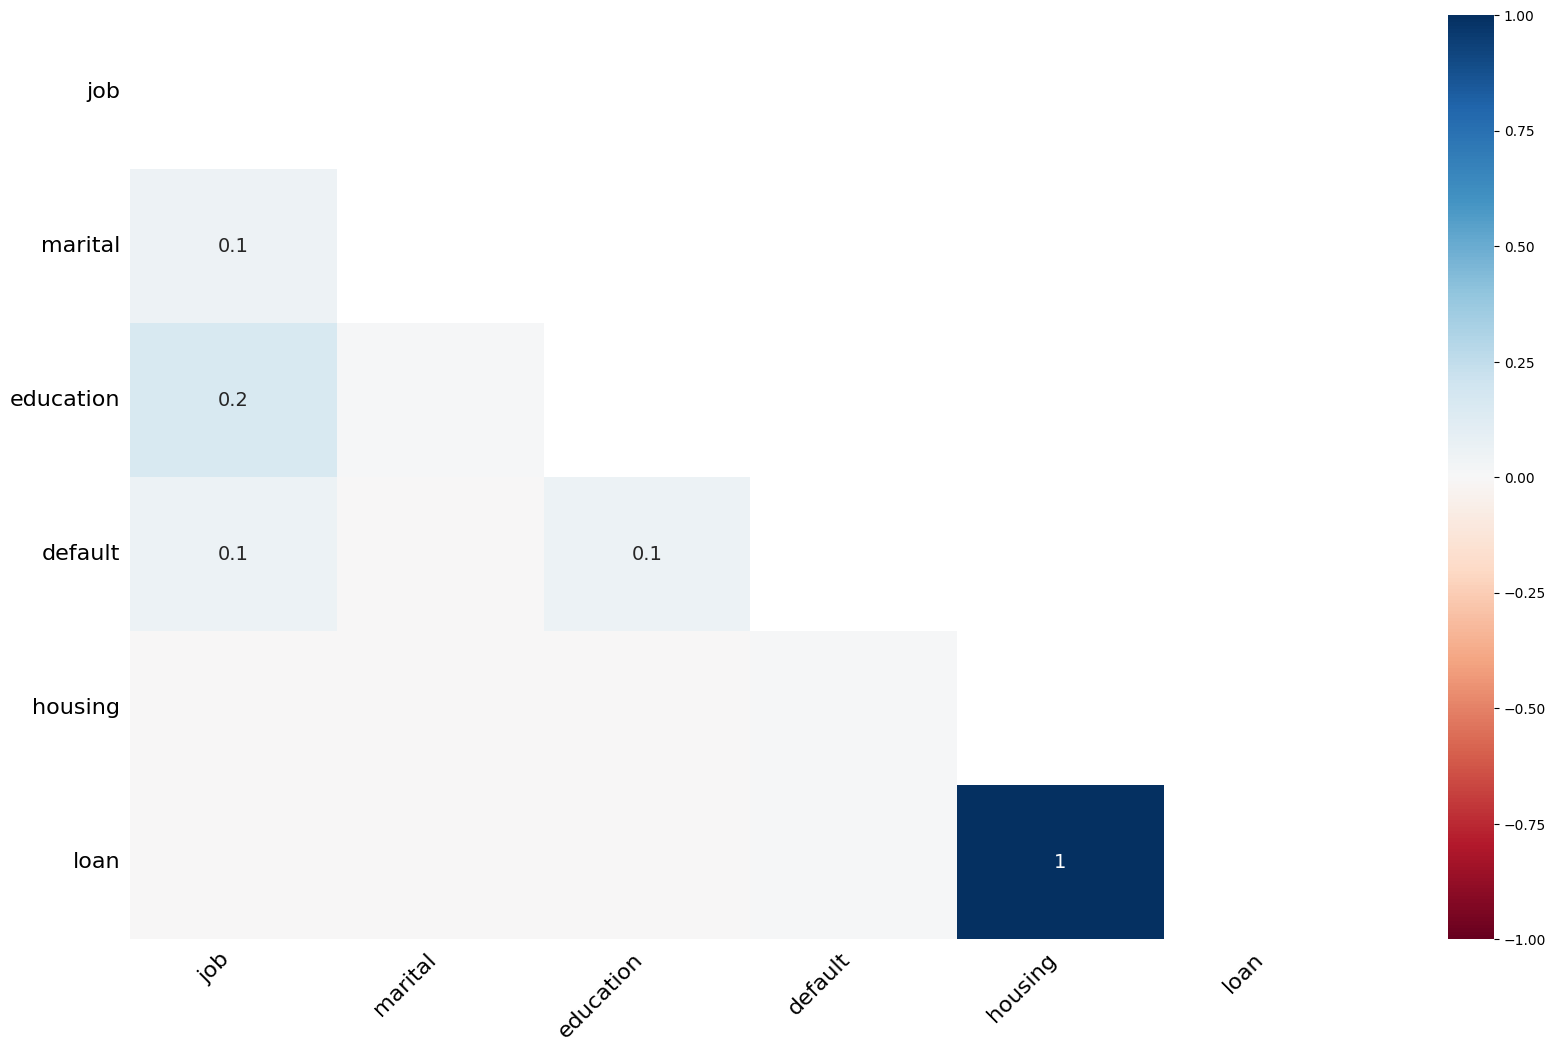

In [21]:
msno.heatmap(df_original)

In [22]:
features_with_safe_range_missing_values = feature_description[(feature_description['datatype']=='O') & (feature_description['percent_missing']>0)&(feature_description['percent_missing']<5)]
features_with_safe_range_missing_values

,datatype,unique_value_count,percent_missing
job,object,12,0.8
marital,object,4,0.2
education,object,8,4.2
housing,object,3,2.4
loan,object,3,2.4


If we drop all the records having missing values in features '`job`', '`marital`', '`education`', '`housing`', '`loan`' we lose around $7\%$ of data.

In [23]:
df_original = df_original[df_original[features_with_safe_range_missing_values.index].isna().any(axis=1)==False]

In [24]:
# After dropping
round(df_original.isna().sum() / len(df_original) * 100, 1)

age                0.0
job                0.0
marital            0.0
education          0.0
default           20.3
housing            0.0
loan               0.0
contact            0.0
month              0.0
campaign           0.0
pdays              0.0
previous           0.0
poutcome           0.0
emp.var.rate       0.0
cons.price.idx     0.0
cons.conf.idx      0.0
euribor3m          0.0
nr.employed        0.0
y                  0.0
dtype: float64

In [25]:
value_proportions = pd.DataFrame(columns=['no','yes'])

value_proportions.loc['overall'] = df_original['y'].value_counts(normalize=True)
value_proportions.loc['default'] = df_original['y'][df_original['default'].isna()].value_counts(normalize=True)
value_proportions

,no,yes
overall,0.888665,0.111335
default,0.948563,0.051437


In [26]:
value_proportions

'|         |       no |       yes |\n|:--------|---------:|----------:|\n| overall | 0.888665 | 0.111335  |\n| default | 0.948563 | 0.0514374 |'

The class imbalance is significantly more in the missing value records of `default` attribute, compared to overall dataset. We can leverage this fact while imputing the missing values in the next **Data Tranformation** section.

### 5 Data Transform

#### 5.1 Imputation
Only `default` attribute remains for imputation. From the above datatable we can see it is highly imbalanced. So, we can apply mode strategy for imputation.

In [27]:
imputer = SimpleImputer(strategy = 'most_frequent')
df_original['default'] = imputer.fit_transform(pd.DataFrame(df_original['default']))
df_original.head()

,age,job,marital,education,default,housing,loan,contact,month,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,43,self-employed,divorced,university.degree,no,no,no,cellular,aug,1,999,1,failure,-2.9,92.201,-31.4,0.884,5076.2,no
1,74,retired,married,high.school,no,yes,no,cellular,aug,1,999,1,failure,-2.9,92.201,-31.4,0.883,5076.2,yes
2,34,technician,single,professional.course,no,yes,no,cellular,aug,2,12,1,success,-2.9,92.201,-31.4,0.883,5076.2,yes
4,27,admin.,single,university.degree,no,no,no,cellular,aug,2,999,0,nonexistent,-2.9,92.201,-31.4,0.879,5076.2,yes
5,36,management,married,university.degree,no,no,no,cellular,aug,2,999,0,nonexistent,-2.9,92.201,-31.4,0.884,5076.2,no


#### 5.2 Encoding

Splitting the dataset into Explanatory **`X`** and Response variable **`y`**.

In [28]:
X, y = df_original.drop(columns=['y']), df_original['y']

#### Ordinal Encoding

`education`

In [29]:
df_original['education'].unique()

array(['university.degree', 'high.school', 'professional.course',
       'basic.6y', 'basic.9y', 'basic.4y', 'illiterate'], dtype=object)

In [30]:
education_mapper = {'professional.course':4,
                    'university.degree':3,
                    'high.school':2,
                    'basic.6y':1,
                    'basic.9y':1, 
                    'basic.4y':1, 
                    'illiterate':0}
X['education'].replace(education_mapper, inplace=True)

In [31]:
X['education']

0        3
1        2
2        4
4        3
5        3
        ..
41182    3
41183    3
41184    4
41186    2
41187    1
Name: education, Length: 38245, dtype: int64

#### Dummies Encoding

In [32]:
X = pd.get_dummies(X, drop_first=True)
y = pd.get_dummies(y, drop_first=True)

In [33]:
X.head()

,age,education,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_nonexistent,poutcome_success
0,43,3,1,999,1,-2.9,92.201,-31.4,0.884,5076.2,...,0,0,0,0,0,0,0,0,0,0
1,74,2,1,999,1,-2.9,92.201,-31.4,0.883,5076.2,...,0,0,0,0,0,0,0,0,0,0
2,34,4,2,12,1,-2.9,92.201,-31.4,0.883,5076.2,...,0,0,0,0,0,0,0,0,0,1
4,27,3,2,999,0,-2.9,92.201,-31.4,0.879,5076.2,...,0,0,0,0,0,0,0,0,1,0
5,36,3,2,999,0,-2.9,92.201,-31.4,0.884,5076.2,...,0,0,0,0,0,0,0,0,1,0


In [34]:
print(X.columns)

Index(['age', 'education', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_married',
       'marital_single', 'default_yes', 'housing_yes', 'loan_yes',
       'contact_telephone', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_nonexistent', 'poutcome_success'],
      dtype='object')


#### 5.3 Binning

`age`

In [35]:
def age_mapper(x):
    if x<21: return 0
    elif x<=30: return 1
    elif x<=40: return 2
    elif x<=50: return 3
    elif x<=60: return 4
    else: return 5

X['age'] = X['age'].apply(age_mapper)

### 6 Fitting Model

#### 6.1 Dividing Dataset into Train and Test sets

As dataset is highly imbalanced, Train-Test split must be **stratified**.

In [36]:
# split train 80% & test 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state=50, stratify=y)

In [37]:
print('train\n',y_train.value_counts(normalize=True),'\n\ntest\n',y_test.value_counts(normalize=True))

train
 yes
0      0.888678
1      0.111322
dtype: float64 

test
 yes
0      0.888613
1      0.111387
dtype: float64


#### 6.2 Model building

##### UDF for measuring time to train the best estimator model and its size

In [38]:
def model_measure(estimator, X_train, y_train):
    global model_count
    start_time = perf()
    trained_model = estimator.fit(X_train, y_train)
    model_time_to_train = perf() - start_time

    dir_path = './model_files/Q1/'

    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    with open(f'{dir_path}{str(model_count)}.pkl','wb') as file:
        pickle.dump(trained_model, file)

    # measure the model size
    PATH = f'{dir_path}{str(model_count)}.pkl'
    model_size = os.path.getsize(PATH)/1024

    model_count += 1
    return trained_model, model_time_to_train, model_size


In [39]:
def eval_metrics(test, pred):
    return recall_score(test, pred, average='weighted'), accuracy_score(test, pred), precision_score(test, pred), roc_auc_score(test, pred), confusion_matrix(test, pred)

##### Hyperparameter Tuning and Cross Validation

In [40]:
# create a decision tree classifier instance
DTclf = DecisionTreeClassifier()

# weighted recall is chosen as performance metrics
weighted_recall = make_scorer(recall_score, average='weighted')

# define the hyperparameter grid to search over
param_grid = {
    'criterion':['gini','entropy'],
    'max_depth': [*range(2,6)],
    'min_samples_split': [2, 3, 4, 5, 6, 8],
    'min_samples_leaf': [5, 10, 12, 15, 20, 30],
}

# create a GridSearchCV instance with the decision tree classifier and hyperparameter grid
grid_search = GridSearchCV(DTclf, param_grid=param_grid, scoring=weighted_recall, cv=5)

# fit the GridSearchCV instance on the data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5],
                         'min_samples_leaf': [5, 10, 12, 15, 20, 30],
                         'min_samples_split': [2, 3, 4, 5, 6, 8]},
             scoring=make_scorer(recall_score, average=weighted))

##### Test Model

In [41]:
vanila_model = DecisionTreeClassifier(**grid_search.best_params_)

# measure time to train the best estimator model and its size
best_clf, dt_time_to_train, dt_model_size = model_measure(vanila_model, X_train, y_train)

dt_train_score = grid_search.best_score_
y_pred = best_clf.predict(X_test)

dt_test_score, dt_test_acc, dt_test_prec, dt_test_roc, conf_mat = eval_metrics(y_test, y_pred)
print('Best Train Score:',round(dt_train_score,6),',Test Score:', round(dt_test_score,6))

Best Train Score: 0.901719 ,Test Score: 0.902602


##### Confusion Matrix

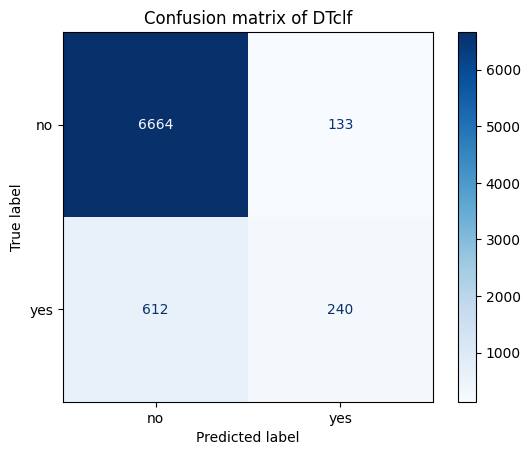

In [42]:
# create the confusion matrix display
cmd = ConfusionMatrixDisplay(conf_mat, display_labels=['no', 'yes'])

# plot the confusion matrix
cmd.plot(cmap=plt.cm.Blues)

# add a title and axis labels
plt.title('Confusion matrix of DTclf')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# show the plot
plt.show()

##### Storing model train & test metrics

In [43]:
model_scores = pd.DataFrame(columns=['train_whtd_rcl', 'test_whtd_rcl', 'test_acc', 'test_prec', 'test_roc','time_to_train(ns)','model_size(KB)'])
model_scores.loc['DTclf'] = [dt_train_score, dt_test_score, dt_test_acc, dt_test_prec, dt_test_roc, dt_time_to_train, dt_model_size]
model_scores

,train_whtd_rcl,test_whtd_rcl,test_acc,test_prec,test_roc,time_to_train(ns),model_size(KB)
DTclf,0.901719,0.902602,0.902602,0.643432,0.631061,122392500.0,5.635742


BEST PARAMETERS

In [44]:
print("Best hyperparameters: ", grid_search.best_params_)

Best hyperparameters:  {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 20, 'min_samples_split': 3}


#### Tree Graphics

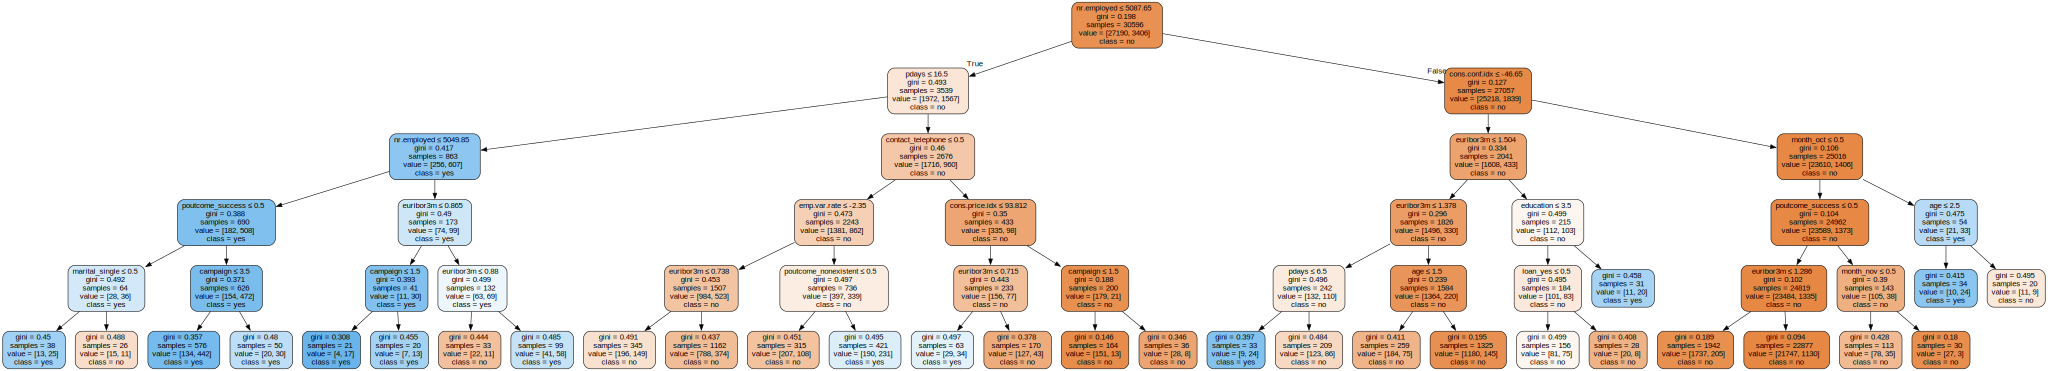

In [45]:
import graphviz
dot_data = export_graphviz(best_clf, out_file=None, feature_names=X.columns,
                           class_names=['no','yes'], filled=True, rounded=True,
                           special_characters=True)
graph = graphviz.Source(dot_data)
graph

## NB Classifier 🤓

### Have to follow steps from 1 to 5 of Decision Tree Classifier. After that...

In [46]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.model_selection import cross_val_score

In [47]:
X_nb = X.copy()

In [48]:
X_nb.describe().loc['min'].min()

-50.8

Numerical features have negetive values in it. Need to be normalised, otherwise model fitting process would generate error.

In [49]:
numerical_features = list(X.dtypes[X.dtypes=='float'].index)
numerical_features

['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

##### Normalization of continuous features

In [50]:
X_nb[numerical_features] = X_nb[numerical_features].apply(lambda x:(x - x.min()) / (x.max() - x.min()))
X_nb.describe().loc['min'].min()

0.0

##### NB Classifier Models

In [51]:
nb_models = {'gnb':GaussianNB(),
            'mnb':MultinomialNB(),
            'bnb':BernoulliNB()}

##### Performance metric ~ Weighted Recall

In [52]:
weighted_recall = make_scorer(recall_score, average='weighted')

##### Train-Test split

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_nb, y, test_size=0.2, random_state=50, stratify=y)

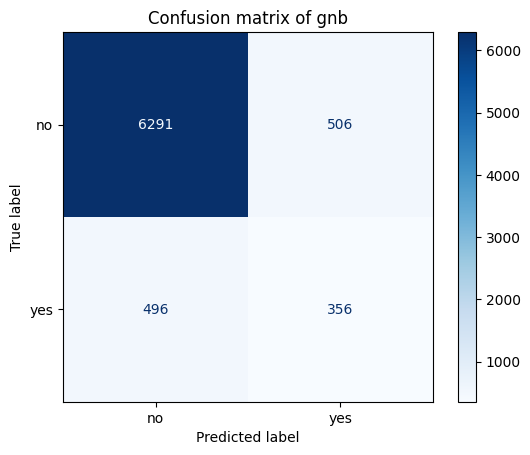

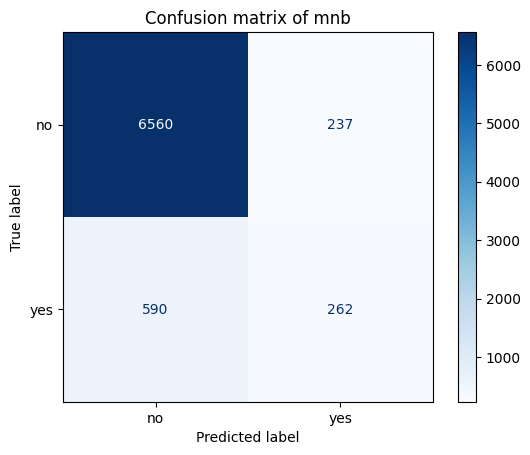

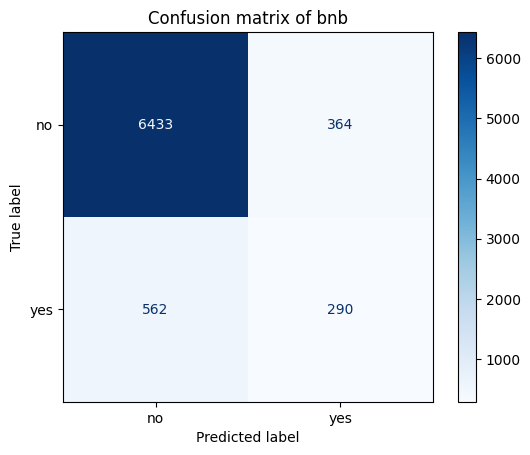

In [54]:
for model in nb_models:
    # average of all performance metrics calculated from each fold
    nb_mean_train_score = cross_val_score(estimator=nb_models[model],X=X_train,y=y_train,cv=5, scoring=weighted_recall).mean()

    fit_model, time_to_train, model_size = model_measure(nb_models[model],X_train, y_train)

    # calculate predicted values
    y_pred = fit_model.predict(X_test)
    
    nb_test_score, nb_test_acc, nb_test_prec, nb_test_roc, conf_mat = eval_metrics(y_test, y_pred)

    model_scores.loc[model] = [nb_mean_train_score, nb_test_score, nb_test_acc, nb_test_prec, nb_test_roc, time_to_train, model_size]

    # create the confusion matrix display
    cmd = ConfusionMatrixDisplay(conf_mat, display_labels=['no', 'yes'])

    # plot the confusion matrix
    cmd.plot(cmap=plt.cm.Blues)

    # add a title and axis labels
    plt.title(f'Confusion matrix of {model}')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    # show the plot
    plt.show()

##### Compare Performance b/w DTClassifier & NBClassifier models

In [55]:
model_scores

,train_whtd_rcl,test_whtd_rcl,test_acc,test_prec,test_roc,time_to_train(ns),model_size(KB)
DTclf,0.901719,0.902602,0.902602,0.643432,0.631061,122392500.0,5.635742
gnb,0.870637,0.869002,0.869002,0.412993,0.671698,33630600.0,2.317383
mnb,0.889071,0.891881,0.891881,0.525050,0.636322,20652300.0,2.334961
bnb,0.876651,0.878938,0.878938,0.443425,0.643411,38823300.0,2.352539
